<a href="https://colab.research.google.com/github/FrankAyalaC/sensitivity_analysis_WW3/blob/main/Plotting_error_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import os
from datetime import datetime,timedelta
import glob as glob
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

newparams = { 'axes.grid': False,
             'lines.linewidth': 1.5, 'lines.linewidth': 2,
             'ytick.labelsize':15,
             'xtick.labelsize':15,
             'axes.labelsize':16,
             'axes.titlesize':18,
            'legend.fontsize':14,
             'figure.titlesize':16,
             'font.family':'Helvetica Light'}
plt.rcParams.update(newparams)

from datetime import datetime,timedelta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_track=pd.read_csv('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/df_track.csv',
                     sep=' ',names=['date','lat','lon','wind','id','color','cat'])

In [4]:
df_track=df_track.set_index('date')
df_interest=df_track.iloc[:17]

In [5]:
data_array=df_interest.index
cat_array=df_interest.cat.values
dates_org=pd.to_datetime(data_array)
data_str=dates_org.strftime('%m/%d/%H')

In [6]:
def get_index_positions(list_of_elems, element):
  ''' Returns the indexes of all occurrences of give element in
  the list- listOfElements '''
  index_pos_list = []
  index_pos = 0
  while True:
      try:
          # Search for item in list from indexPos to the end of list
          index_pos = list_of_elems.index(element, index_pos)
          # Add the index position in list
          index_pos_list.append(index_pos)
          index_pos += 1
      except ValueError as e:
          break
  return index_pos_list

In [7]:
categories=['H1','H2','H3','H4','H5']
dic_cats={}

In [8]:
for cat in categories:
  dic_cats[cat]=get_index_positions(cat_array.tolist(),cat)  

In [9]:
ds_specs=np.load('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/efth_spec.npz',
                 allow_pickle=True)
ds_specs_v2=np.load('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/efth_spec_v2.npz',
                 allow_pickle=True)

In [10]:
specs_sw3=ds_specs['sw3'].flatten()[0]
specs_sw4=ds_specs_v2['sw4'].flatten()[0]
specs_sw6=ds_specs_v2['sw6'].flatten()[0]

In [11]:
freqs=[0.042, 0.0462, 0.05082001, 0.05590201, 0.06149221, 0.06764144,
    0.07440558, 0.08184613, 0.09003075, 0.09903383, 0.1089372, 0.1198309,
    0.131814, 0.1449955, 0.159495, 0.1754445, 0.192989, 0.2122879, 0.2335167,
    0.2568683, 0.2825552, 0.3108107, 0.3418918, 0.376081, 0.4136891,
    0.455058, 0.5005639, 0.5506203, 0.6056823, 0.6662505]

In [12]:
def arranging_axes(ax,xlabel):
  ax.set_xticks(np.linspace(0,36,5))
  ax.set_xticklabels(list(map(str,np.linspace(0,360,5,dtype=int))))
  ax.set_yticks(np.arange(0,31,10))
  ax.set_yticklabels(np.round([freqs[0],freqs[9],freqs[19],freqs[29]],2))
  if xlabel==1:
    ax.set_xlabel('Direction [°]') 

In [13]:
class spec_example:

  def __init__(self, data_spec,param_name,switch_name):
    self.switch_name = switch_name
    self.data = data_spec
    self.name = param_name
    self.quadrants=['Center','Quadrant I','Quadrant II','Quadrant III','Quadrant IV']
    self.percentages=['-10','-30','-50','+10','+30','+50']

  def computing_example(self,idx_time,quad):
    self.list_result=[]
    self.min_values_wdef,self.max_values_wdef=[],[]
    self.min_values,self.max_values=[],[]
    self.objs=[]
    self.perc_dif_means=[]
    for param in self.data.keys():
      self.def_name=self.name+'/0'
      if param != self.def_name and param[:param.find('/')]==self.name:
        self.default=np.reshape(self.data[self.def_name][:85,:,:],(17,5,30,36)) 
        self.obj=np.reshape(self.data[param][:85,:,:],(17,5,30,36))
        self.default=self.default[idx_time,quad,:,:]
        self.obj=self.obj[idx_time,quad,:,:]
        #self.result=(np.abs((obj-default)/(np.nanmax(default))))*100
        self.result=((self.obj-self.default)/(np.nanmax(self.default)))*100
        self.list_result.append(self.result)
        self.objs.append(self.obj)
        self.a_wdef=min([np.nanmin(self.obj),np.nanmin(self.default)])
        self.b_wdef=max([np.nanmax(self.obj),np.nanmax(self.default)])
        self.min_values_wdef.append(self.a_wdef)
        self.max_values_wdef.append(self.b_wdef)
        self.min_values.append(np.nanmin(self.obj))
        self.max_values.append(np.nanmax(self.obj))
        self.perc_dif_means.append(((np.mean(self.obj)-np.mean(self.default))/(np.mean(self.default)))*100)
    return self.default,self.objs,self.list_result,self.min_values,self.max_values,self.min_values_wdef,self.max_values_wdef,self.perc_dif_means

  def computing_norm_diff_map(self,idx_time,quad):
    # Init computations
    self.default,self.objs,self.list_result,self.min_values,self.max_values,self.min_values_wdef,self.max_values_wdef,self.perc_dif_means = self.computing_example(idx_time,quad)
    
    # Calculating mean map
    self.zeros=np.zeros(self.default.shape)        
    for el in self.list_result:
      self.zeros=self.zeros+el
    self.final_value=self.zeros/6 
    return self.final_value

  def plotting_only_per_example(self,idx_time,quad,cat_array,data_str,percent):
    # Init computations
    self.default,self.objs,self.list_result,self.min_values,self.max_values,self.min_values_wdef,self.max_values_wdef,self.perc_dif_means = self.computing_example(idx_time,quad)
    self.idx_percent=self.percentages.index(percent)

    self.fig,[self.ax1,self.ax2,self.ax3]=plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
    
    # Plot for objective value
    self.cf1=self.ax1.imshow(self.objs[self.idx_percent],vmin=self.min_values_wdef[self.idx_percent],
                             vmax=self.max_values_wdef[self.idx_percent],extent=[0,36,0,30],origin='lower',cmap='magma_r')
    self.ax1.set_title('Default' + percent + '%')
    self.ax1.set_ylabel(data_str[idx_time]+'\n Frequency [Hz]', multialignment='center')
  
    # Plot for default value
    self.ax2.imshow(self.default,vmin=self.min_values_wdef[self.idx_percent],vmax=self.max_values_wdef[self.idx_percent],
                            extent=[0,36,0,30],origin='lower',cmap='magma_r')
    self.ax2.set_title('Default')

    # Plot for result 
    self.norm = colors.TwoSlopeNorm(vmin=self.list_result[self.idx_percent].min(), 
                                    vcenter=0, vmax=self.list_result[self.idx_percent].max())
    self.cf2=self.ax3.imshow(self.list_result[self.idx_percent],extent=[0,36,0,30],origin='lower',norm=self.norm,cmap='RdBu_r')
    self.ax3.set_ylabel('Default', multialignment='center')
    self.ax3.set_title(r'$\frac{(Default'+percent+'\%)- Default}{\max (Default)}$')

    # First colorbar
    self.cax1= self.fig.add_axes([self.ax1.get_position().x0,self.ax1.get_position().y0-0.15,
                                  0.5,0.02])
    self.cbar=plt.colorbar(self.cf1,cax=self.cax1,orientation="horizontal",pad=0.12)
    self.cbar.set_label(r'Energy [$m^{2}/Hz$]',fontsize=17)
    self.cbar.ax.tick_params(labelsize=16)

    # Second colorbar
    self.cax2= self.fig.add_axes([self.ax3.get_position().x1+0.01,self.ax3.get_position().y0,
                                  0.01,self.ax3.get_position().height])
    self.cbar2=plt.colorbar(self.cf2,cax=self.cax2,orientation="vertical",pad=0.12)
    self.cbar2.set_label(r'Normalized difference [%]',fontsize=17)

    arranging_axes(self.ax1,1)
    arranging_axes(self.ax2,1)
    arranging_axes(self.ax3,1)

    plt.suptitle('Example for category ' + cat_array[idx_time] + ' - parameter '+ self.name + ' - ' + 
                 self.quadrants[quad]+ ' - '+self.switch_name,fontsize=18,y=0.94)
    plt.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/only_per_example.png',
                dpi=1000,bbox_inches='tight',pad_inches=0.05)
    plt.show()

  def plotting_all_per_example(self,idx_time,quad,data_str):
    # Init computations
    self.default,self.objs,self.list_result,self.min_values,self.max_values,self.min_values_wdef,self.max_values_wdef,self.perc_dif_means = self.computing_example(12,1)

    #fig,axes=plt.subplots(6,3,figsize=(15,30),sharex=True,sharey=True)
    self.fig=plt.figure(figsize=(18,11))
    self.gs = gridspec.GridSpec(4, 6,self.fig,wspace=-0.35,hspace = 0.5)

    # Plot for the default 
    self.ax1=self.fig.add_subplot(self.gs[1,3])
    self.cf1=self.ax1.imshow(self.default,vmin=self.min_values_wdef[0],vmax=self.max_values_wdef[0],
                            extent=[0,36,0,30],origin='lower',cmap='magma_r')
    self.ax1.set_ylabel(data_str[idx_time]+'\n Frequency [Hz]', multialignment='center')
    self.ax1.set_title('Default')
    arranging_axes(self.ax1,0)

    self.cax1= self.fig.add_axes([self.ax1.get_position().x1+0.01,self.ax1.get_position().y0,
                                    0.01,self.ax1.get_position().height])
    self.cbar1=plt.colorbar(self.cf1,cax=self.cax1,orientation="vertical",pad=0.12)
    self.cbar1.set_label(r'Energy [$m^{2}/Hz$]',fontsize=15)
    self.cbar1.ax.tick_params(labelsize=15)

    for idx in range(len(self.list_result)):
      # Plots for variations 
      self.ax2=self.fig.add_subplot(self.gs[0,idx])
      plt.setp(self.ax2.get_yticklabels(), visible=False)                 
      self.cf2=self.ax2.imshow(self.objs[idx],vmin=min(self.min_values),vmax=max(self.max_values),
                          extent=[0,36,0,30],origin='lower',cmap='magma_r')
      self.ax2.set_title('Default'+self.percentages[idx])

      # Plot for normalized differences
      self.ax3=self.fig.add_subplot(self.gs[2,idx])   
      plt.setp(self.ax3.get_yticklabels(), visible=False) 
      self.list_result=np.array(self.list_result)                      
      norm = colors.TwoSlopeNorm(vmin=self.list_result.min(), vcenter=0, vmax=self.list_result.max())
      self.cf3=self.ax3.imshow(self.list_result[idx],extent=[0,36,0,30],origin='lower',norm=norm,cmap='RdBu_r')

      if idx==0:
        arranging_axes(self.ax2,1)
        arranging_axes(self.ax3,1)
        self.ax2.set_ylabel(data_str[idx_time]+'\n Frequency [Hz]', multialignment='center')
        self.ax3.set_ylabel(data_str[idx_time]+'\n Frequency [Hz]', multialignment='center')
      else:
        arranging_axes(self.ax2,0)
        arranging_axes(self.ax3,0)

    # Colorbar for variations
    self.cax2= self.fig.add_axes([self.ax2.get_position().x1+0.01,self.ax2.get_position().y0,
                        0.01,self.ax2.get_position().height])
    self.cbar2=plt.colorbar(self.cf2,cax=self.cax2,orientation="vertical",pad=0.12)
    self.cbar2.set_label(r'Energy [$m^{2}/Hz$]',fontsize=15)
    self.cbar2.ax.tick_params(labelsize=15)

    # Colorbar for normalized differences
    self.cax3= self.fig.add_axes([self.ax3.get_position().x1+0.01,self.ax3.get_position().y0,
                        0.01,self.ax3.get_position().height])
    self.cbar3=plt.colorbar(self.cf3,cax=self.cax3,orientation="vertical",pad=0.12)
    self.cbar3.set_label(r'Norm. difference [%]',fontsize=15)
    self.cbar3.ax.tick_params(labelsize=15)
    
    self.final_value=self.computing_norm_diff_map(idx_time,quad)

    # Plot for mean map
    self.ax_final=self.fig.add_subplot(self.gs[3,3])
    self.norm_f = colors.TwoSlopeNorm(vmin=self.final_value.min(), vcenter=0, vmax=self.final_value.max())
    self.cf_final=self.ax_final.imshow(self.final_value,extent=[0,36,0,30],origin='lower',norm=self.norm_f,cmap='RdBu_r')
    #self.ax_final.set_title('Mean normalized differences map')
    arranging_axes(self.ax_final,1)
    
    # Colorbar for mean map
    self.cax_final= self.fig.add_axes([self.ax_final.get_position().x1+0.01,self.ax_final.get_position().y0,
                           0.01,self.ax_final.get_position().height])
    self.cbar4=plt.colorbar(self.cf_final,cax=self.cax_final,orientation="vertical",pad=0.12)
    self.cbar4.set_label(r'Norm. difference [%]',fontsize=15)
    self.cbar4.ax.tick_params(labelsize=15)

    plt.suptitle('Normalized differences maps - category ' + cat_array[idx_time] + ' - parameter '+ self.name + ' - ' + 
                 self.quadrants[quad]+ ' - '+self.switch_name,fontsize=18,y=0.95)
    
    # Saving the figure
    plt.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/all_per_example.png',
              dpi=1000,bbox_inches='tight',pad_inches=0.05)
    plt.show()
  
  def plotting_integral_plot(self,cat_array,dic_cats):
    self.cats=np.unique(cat_array)
    self.results_array=np.zeros((5,5,7))
    for idx,cat in enumerate(self.cats):
      self.element=dic_cats[cat][0]
      for col in range(5):
        self.default,self.objs,self.list_result,self.min_values,self.max_values,self.min_values_wdef,self.max_values_wdef,self.perc_dif_means = self.computing_example(self.element,col)
        # Computations
        self.sorted_perc_dif_means=[self.perc_dif_means[2],self.perc_dif_means[1],self.perc_dif_means[0],0,
                          self.perc_dif_means[3],self.perc_dif_means[4],self.perc_dif_means[5]]
        self.results_array[idx,col,:]=self.sorted_perc_dif_means
    return self.results_array

      # puede buscarse la forma de hacer un return de la info que se requiera (por ejemplo que se retorne un array 5x7)

  def plotting_diff_maps(self,cat_array,dic_cats):
    self.cats=np.unique(cat_array)
    for cat in self.cats:
      self.n_rows=int(len(dic_cats[cat]))
      if self.n_rows<5:
        
        self.fig, self.axes = plt.subplots(nrows=self.n_rows,ncols=5,figsize=(15,int(self.n_rows*3)),sharex=True,sharey=True)

        self.values=np.ones((self.n_rows,5,30,36))
        for idx,element in enumerate(dic_cats[cat]):
          for col in range(5):
            self.values[idx,col,:,:]=self.computing_norm_diff_map(element,col)

        for idx,element in enumerate(dic_cats[cat]):
          for col in range(5):
            self.cf=self.plotting_error_maps(self.fig,self.axes,idx,col,element,self.values[idx,col,:,:],self.values)

        if self.axes.ndim==2:
          self.cax2= self.fig.add_axes([self.axes[-1][-1].get_position().x1+0.02,
                                        (self.axes[-1][-1].get_position().y0+self.axes[-1][-1].get_position().y1)/2,0.015,self.axes[0][-1].get_position().y1/2])
        else:
          self.cax2= self.fig.add_axes([self.axes[-1].get_position().x1+0.02,
                                        self.axes[-1].get_position().y0,0.015,self.axes[-1].get_position().height])
        self.cbar=plt.colorbar(self.cf,cax=self.cax2,orientation="vertical",pad=0.12)
        self.cbar.set_label(r'Normalized difference [%]',fontsize=17)
        self.cbar.ax.tick_params(labelsize=16)
        self.fig.suptitle('Normalized differences maps - category '+cat+ ' - '+self.name+ ' - '+self.switch_name,y=0.95,fontsize=18)
        self.fig.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/norm_diff_maps_'+self.name+'_'+cat+'_'+self.switch_name+'.png',
            dpi=1000,bbox_inches='tight',pad_inches=0.05)
        plt.show()
      else:
        self.fig1, self.axes1 = plt.subplots(nrows=5,ncols=5,figsize=(15,15),sharex=True,sharey=True)
        self.fig2, self.axes2 = plt.subplots(nrows=int(self.n_rows-5),ncols=5,figsize=(15,int((self.n_rows-5)*3)),sharex=True,sharey=True)
        self.values=np.ones((self.n_rows,5,30,36))

        for idx,element in enumerate(dic_cats[cat]):
          for col in range(5):
            self.values[idx,col,:,:]=self.computing_norm_diff_map(element,col)
            
        for idx,element in enumerate(dic_cats[cat]):
          for col in range(5):
            if idx<=4:
              self.cf_init=self.plotting_error_maps(self.fig1,self.axes1,idx,col,element,self.values[idx,col,:,:],self.values)           
            else:
              self.idx_new=idx-5
              self.cf_end=self.plotting_error_maps(self.fig2,self.axes2,self.idx_new,col,element,self.values[idx,col,:,:],self.values)           
        self.cax_init= self.fig1.add_axes([self.axes1[-1][-1].get_position().x1+0.02,(self.axes1[-1][-1].get_position().y0+self.axes1[-1][-1].get_position().y1)/2,
                          0.015,self.axes1[0][-1].get_position().y1/2])
        self.cbar_init=plt.colorbar(self.cf_init,cax=self.cax_init,orientation="vertical",pad=0.12)
        self.cbar_init.set_label(r'Normalized difference [%]',fontsize=17)
        self.cbar_init.ax.tick_params(labelsize=16)

        self.cax_end= self.fig2.add_axes([self.axes2[-1][-1].get_position().x1+0.02,(self.axes2[-1][-1].get_position().y0+self.axes2[-1][-1].get_position().y1)/2,
                          0.015,self.axes2[0][-1].get_position().y1/2])
        self.cbar_end=plt.colorbar(self.cf_end,cax=self.cax_end,orientation="vertical",pad=0.12)
        self.cbar_end.set_label(r'Normalized difference [%]',fontsize=17)
        self.cbar_end.ax.tick_params(labelsize=16)
        self.fig1.suptitle('Normalized differences maps - category '+cat+ ' - '+self.name+ ' - '+self.switch_name,y=0.95,fontsize=18)
        self.fig2.suptitle('Normalized differences maps - category '+cat+ ' - '+self.name+ ' - '+self.switch_name,y=0.95,fontsize=18)
        self.fig1.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/norm_diff_maps_'+self.name+'_'+cat+'_'+self.switch_name+'.png',
            dpi=1000,bbox_inches='tight',pad_inches=0.05)
        self.fig2.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/norm_diff_maps_'+self.name+'_'+cat+'_'+self.switch_name+'_2.png',
            dpi=1000,bbox_inches='tight',pad_inches=0.05)
        plt.show()

  def plotting_error_maps(self,fig,axes,idx,col,element,result,values):
    if axes.ndim==2:
      self.cf=axes[idx][col].imshow(result, cmap='RdBu_r',origin='lower',
                                    vmin=np.nanmin(values),vmax=np.nanmax(values),extent=[0,36,0,30]) 
      arranging_axes(axes[idx][col],0)
      if idx==0:
        if col==0:
          axes[idx][col].set_title('Center')             
        elif col==1:
          axes[idx][col].set_title('Quadrant I')
        elif col==2:
          axes[idx][col].set_title('Quadrant II')
        elif col==3:
          axes[idx][col].set_title('Quadrant III')
        else:
          axes[idx][col].set_title('Quadrant IV')
      if col==0:
        axes[idx][col].set_ylabel(data_str[element]+'\n Frequency [Hz]', multialignment='center')
        axes[idx][col].set_xlabel('Direction [°]') 
    else:
      self.cf=axes[col].imshow(result, cmap='RdBu_r',origin='lower',
                                    vmin=np.nanmin(values),vmax=np.nanmax(values),extent=[0,36,0,30]) 
      arranging_axes(axes[col],0)
      if col==0:
        axes[col].set_ylabel(data_str[element]+'\n Frequency [Hz]', multialignment='center')
        axes[col].set_xlabel('Direction [°]')         
    return self.cf

In [ ]:
example=spec_example(specs_sw3,'SINTHP','ST3')
default,objs,list_result,min_values,max_values,min_values_wdef,max_values_wdef,perc_dif_means=example.computing_example(12,1)

In [ ]:
#example.plotting_only_per_example(12,1,cat_array,data_str,'+50')

In [ ]:
#example.plotting_all_per_example(12,1,data_str)

In [ ]:
#example.plotting_diff_maps(cat_array,dic_cats)

In [14]:
parameter_list_st3=np.unique(np.array(list(map(lambda x: x[:x.find ('/')],list(specs_sw3.keys())))))
parameter_list_st4=np.unique(np.array(list(map(lambda x: x[:x.find ('/')],list(specs_sw4.keys())))))
parameter_list_st6=np.unique(np.array(list(map(lambda x: x[:x.find ('/')],list(specs_sw6.keys())))))

results_final_array_st3=np.ones((len(parameter_list_st3),5,5,7))
results_final_array_st4=np.ones((len(parameter_list_st4),5,5,7))
results_final_array_st6=np.ones((len(parameter_list_st6),5,5,7))

In [15]:
for idx,param in enumerate(parameter_list_st3):
  param_object_st3=spec_example(specs_sw3,param,'ST3')
  #param_object_st3.plotting_diff_maps(cat_array,dic_cats)
  results_final_array_st3[idx,:,:,:]=param_object_st3.plotting_integral_plot(cat_array,dic_cats)

In [16]:
for idx,param in enumerate(parameter_list_st4):
  param_object_st4=spec_example(specs_sw4,param,'ST4')
  #param_object_st4.plotting_diff_maps(cat_array,dic_cats)
  results_final_array_st4[idx,:,:,:]=param_object_st4.plotting_integral_plot(cat_array,dic_cats)

findfont: Font family ['Helvetica Light'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Light'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Light'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Light'] not found. Falling back to DejaVu Sans.


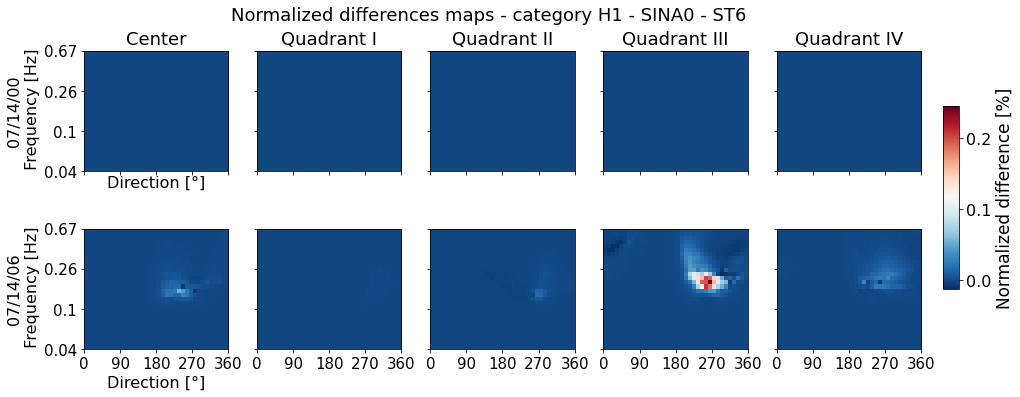

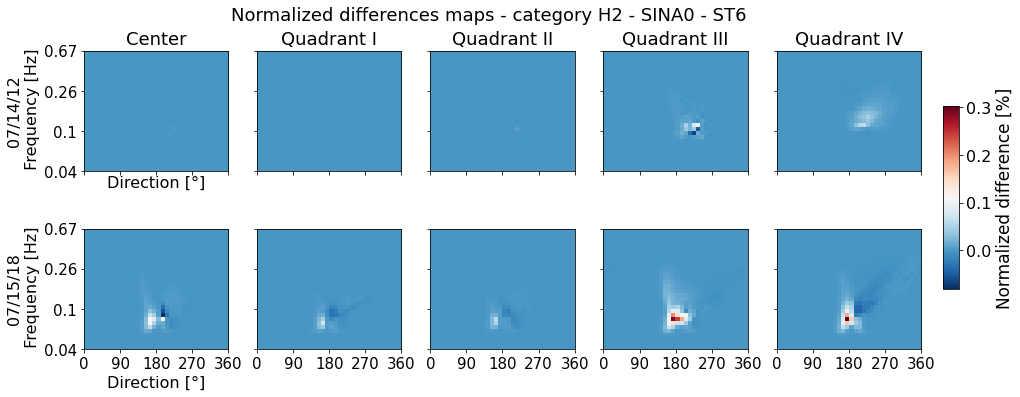

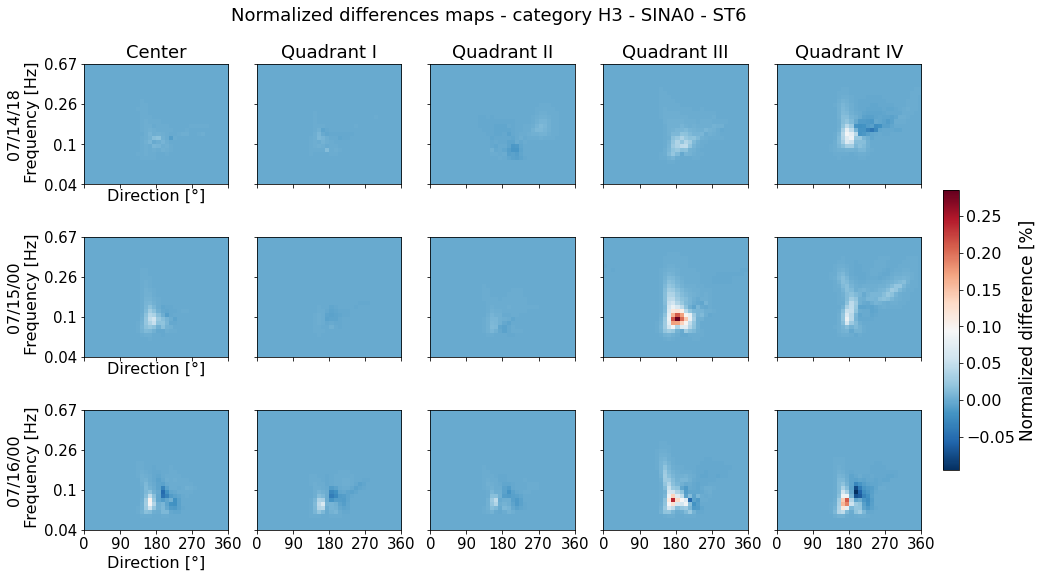

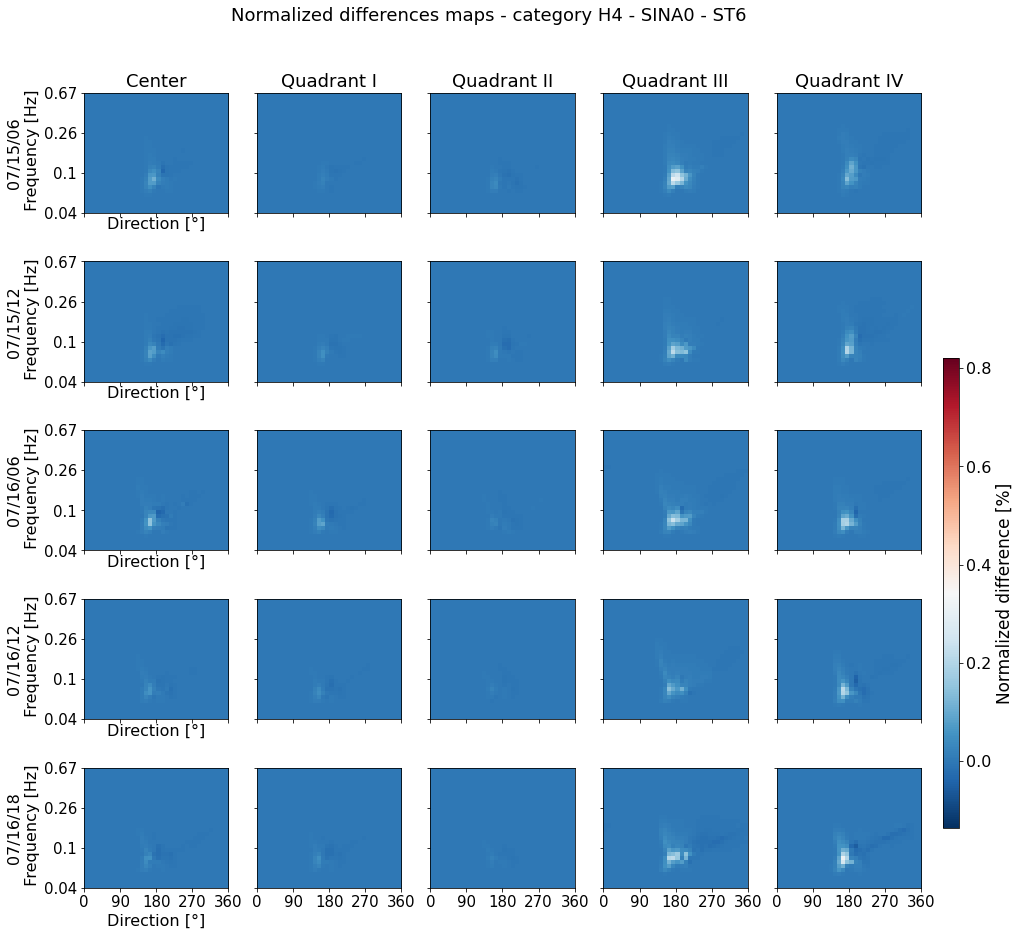

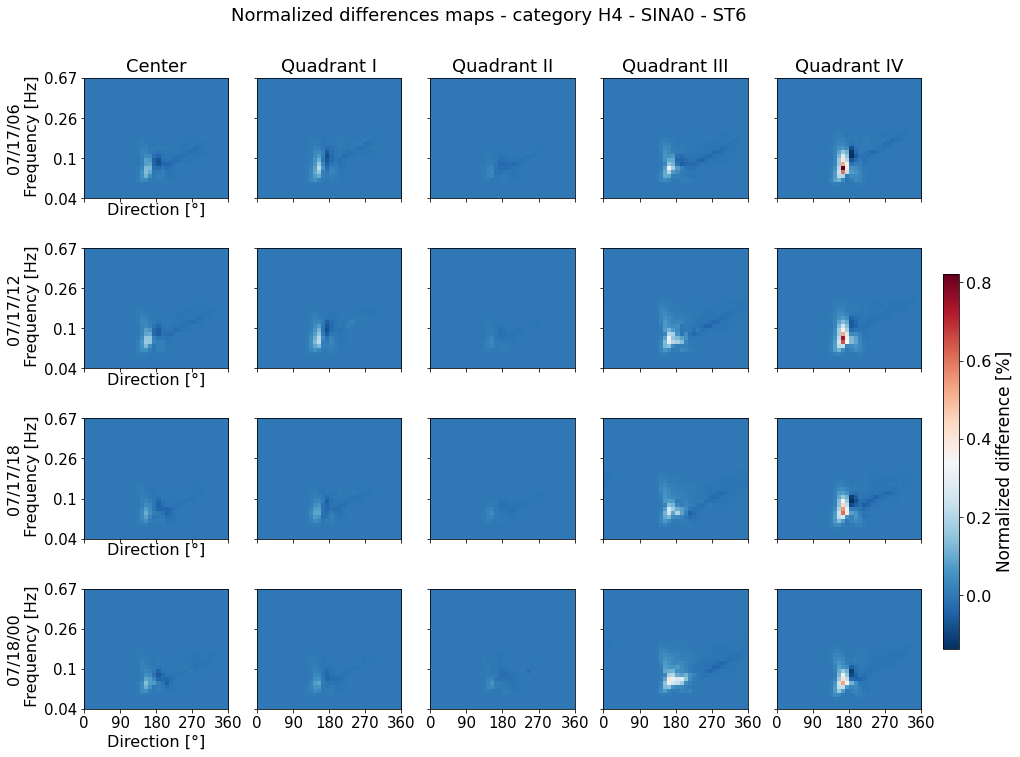

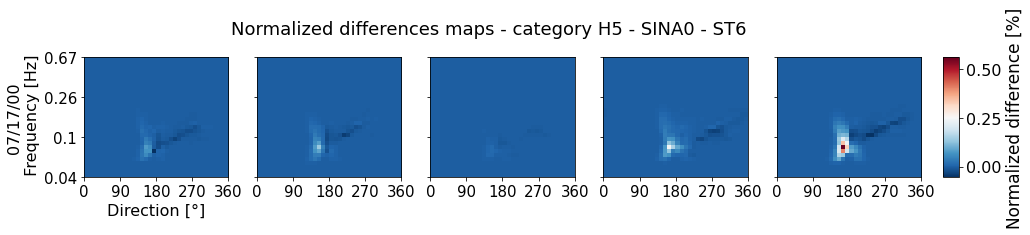

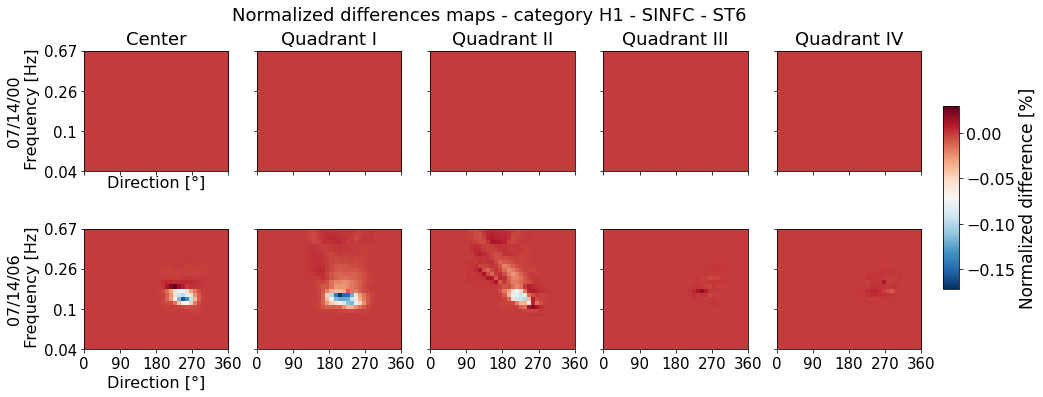

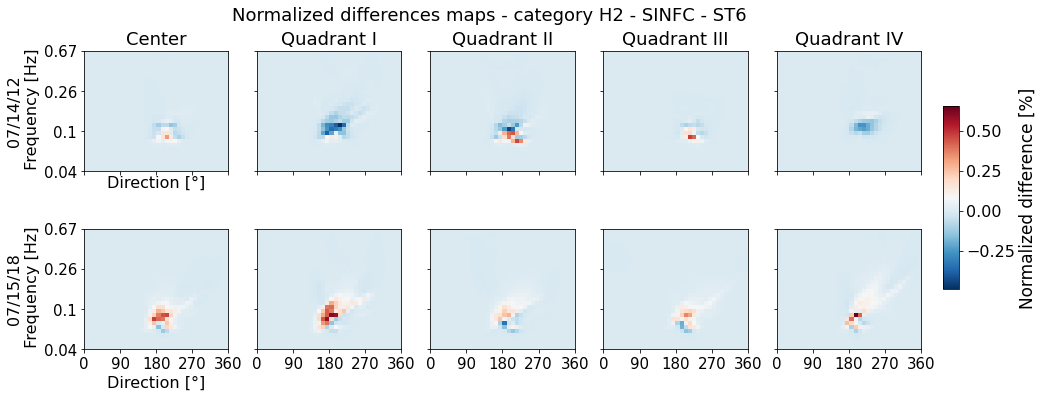

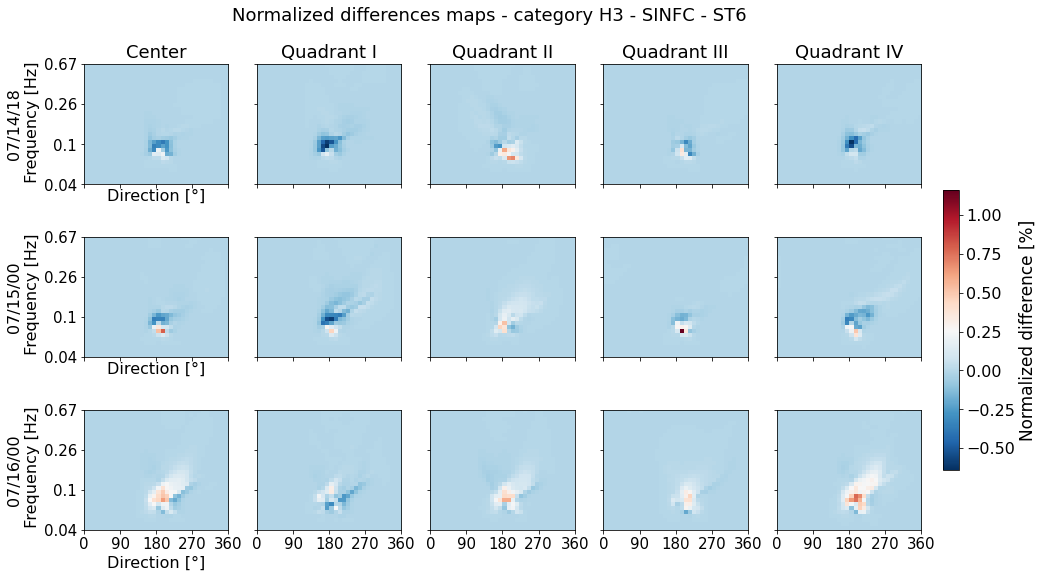

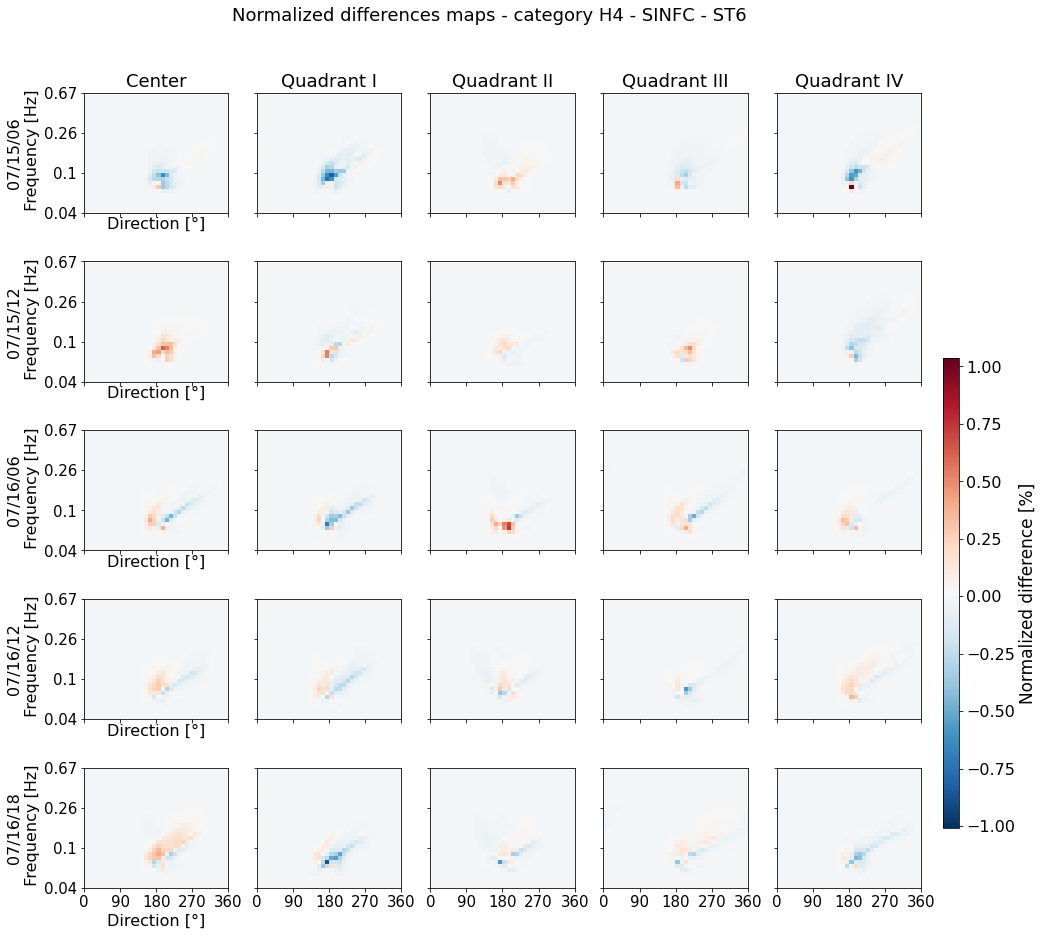

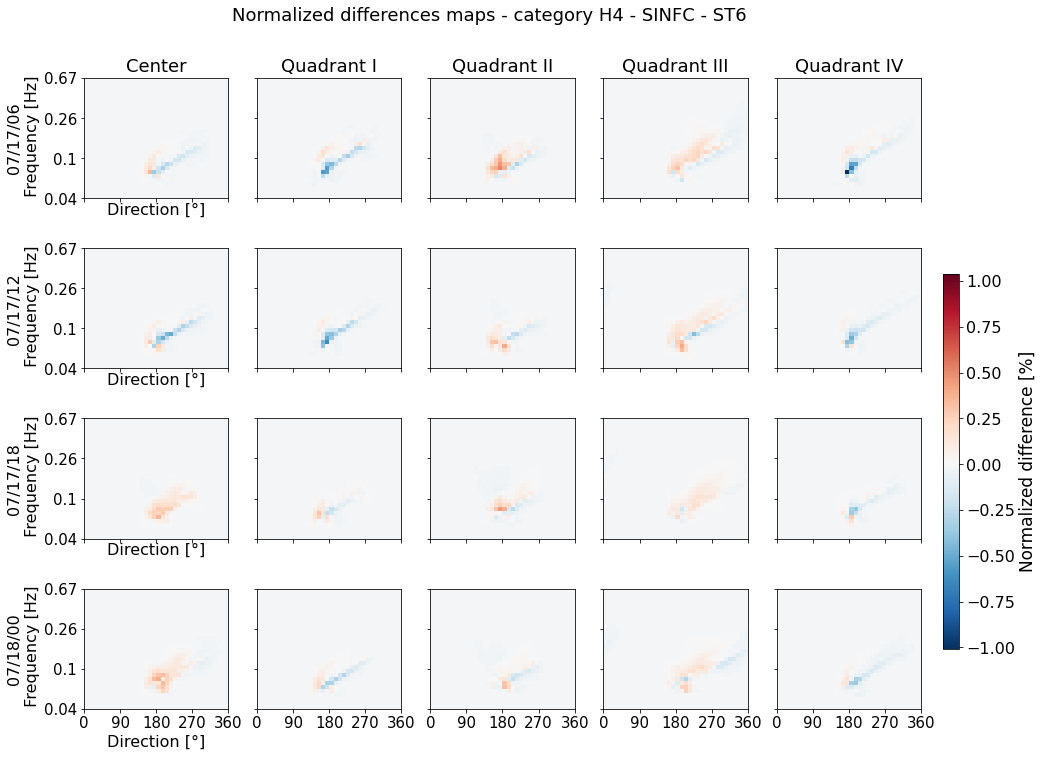

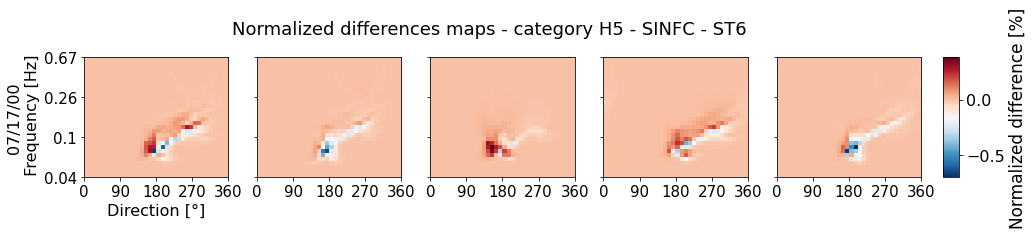

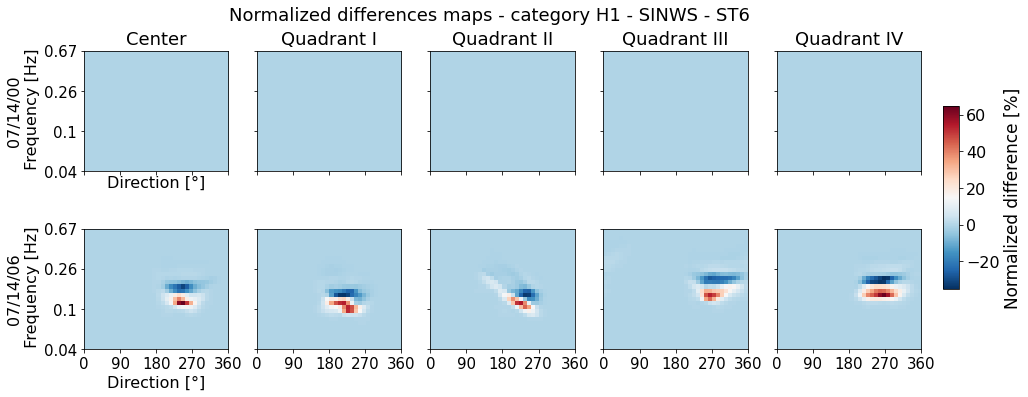

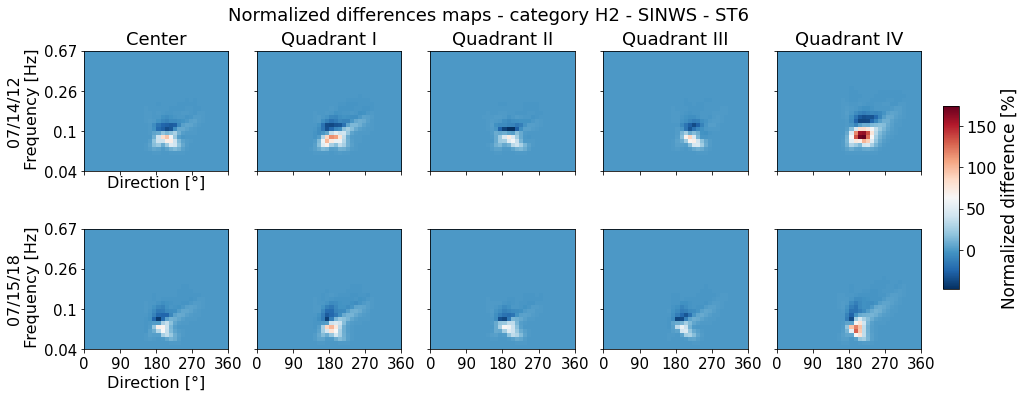

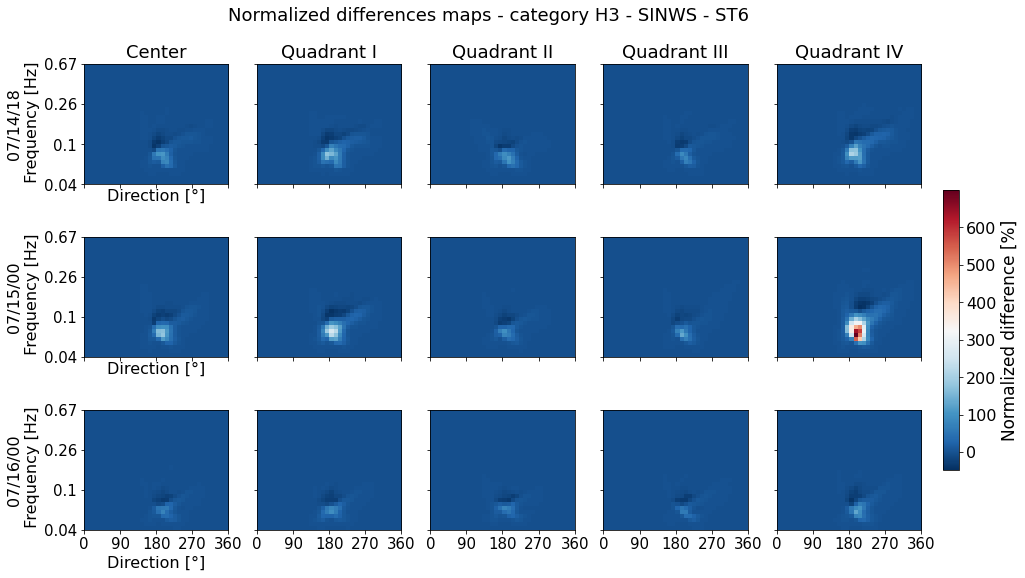

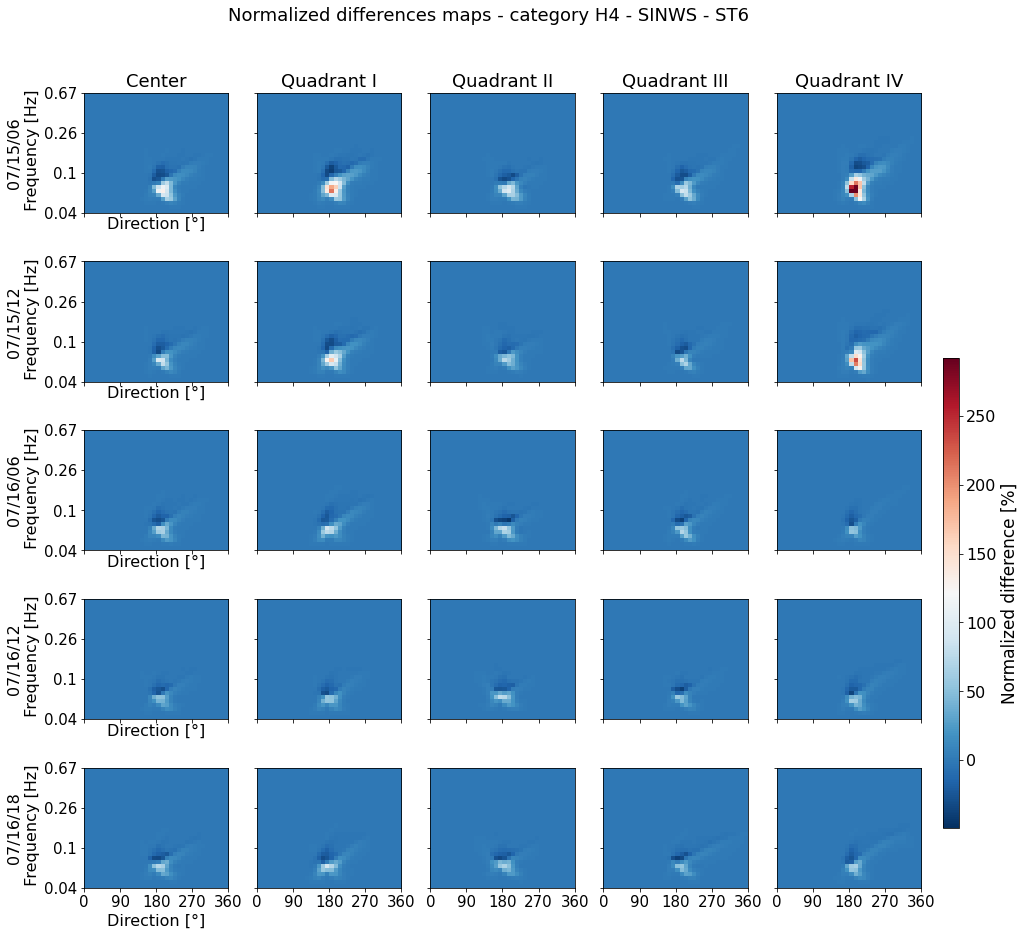

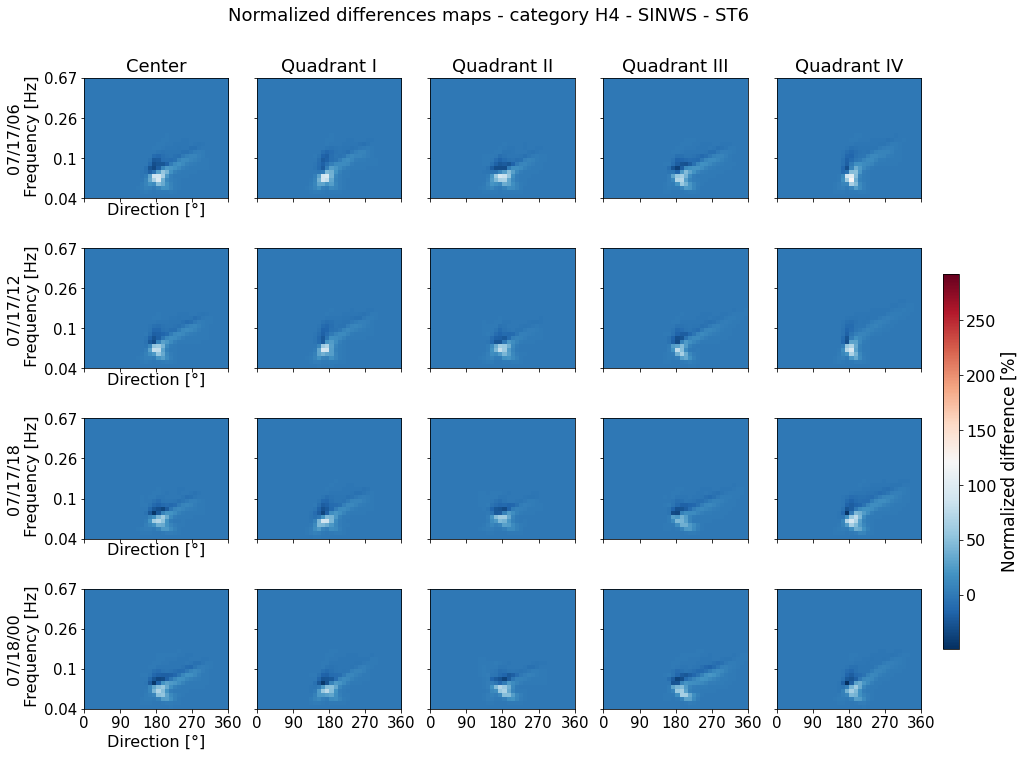

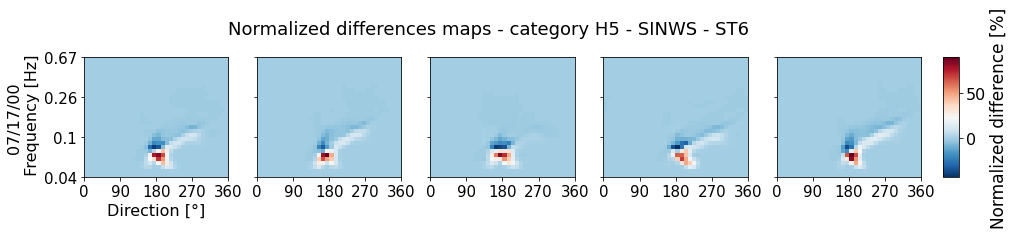

In [17]:
for idx,param in enumerate(parameter_list_st6):
  param_object_st6=spec_example(specs_sw6,param,'ST6')
  param_object_st6.plotting_diff_maps(cat_array,dic_cats)
  results_final_array_st6[idx,:,:,:]=param_object_st6.plotting_integral_plot(cat_array,dic_cats)

In [18]:
def plotting_integral_plot_v2(parameter_list,results_array,switch):
  percents_num=[-0.5,-0.3,-0.1,0,0.1,0.3,0.5]
  cats=np.unique(cat_array)

  for idx_cat in range(len(cats)):
    fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(18,3.3),sharex=True,sharey=True)
    for col in range(5):
    # Plot for integral plot
      for idx_param,element in enumerate(parameter_list):
          axes[col].plot(percents_num,results_array[idx_param,idx_cat,col,:],'-o',label=element,lw=1.3,markersize=5)
          if col == 0:
            axes[col].set_xlabel('Parameter value')
            axes[col].set_ylabel('Norm. diff. of means [%]')
          axes[col].set_xticks(percents_num)
          labels=list(map(lambda x: str(int(x*100))+'%',percents_num))
          labels[3]=''
          axes[col].set_xticklabels(labels,rotation=30,fontsize=14)
    axes[col].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.suptitle('Normalized differences of means per quadrant - category '+cats[idx_cat]+ ' - '+switch,y=1.05,fontsize=18)
    plt.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/norm_diff_means_'+cat+'_'+switch+'.png',
              dpi=1000,bbox_inches='tight',pad_inches=0.05)

findfont: Font family ['Helvetica Light'] not found. Falling back to DejaVu Sans.


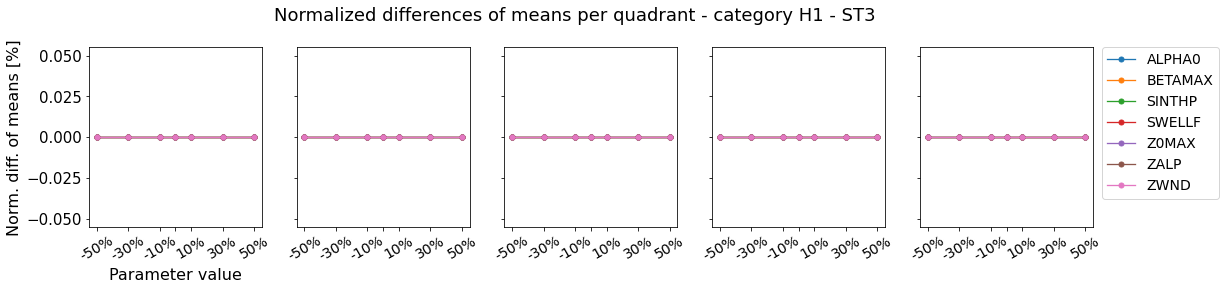

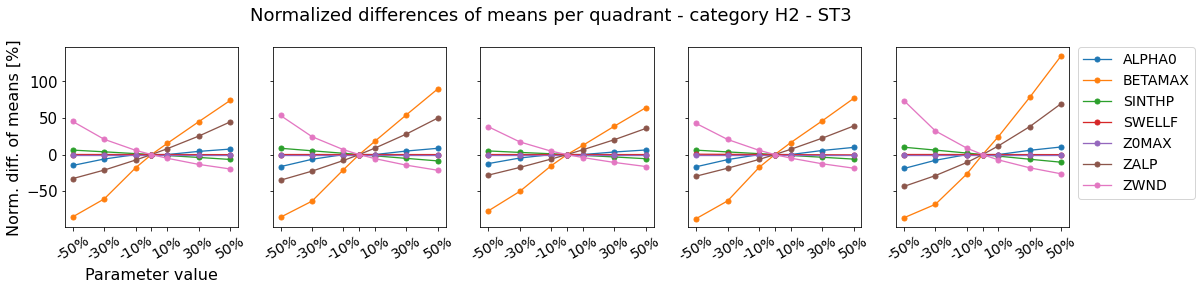

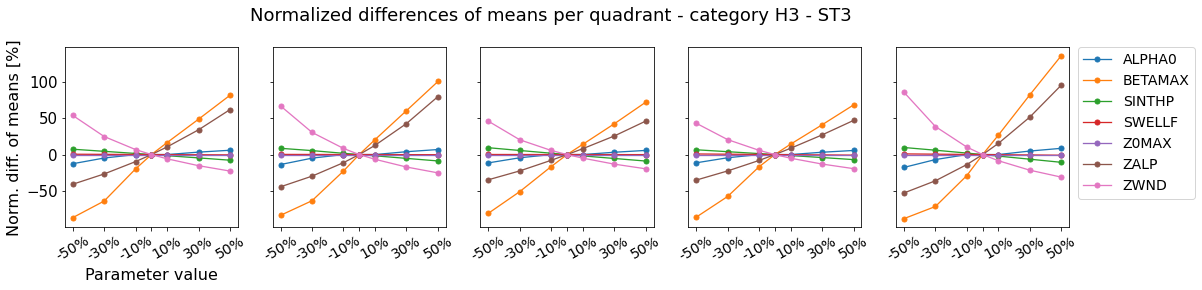

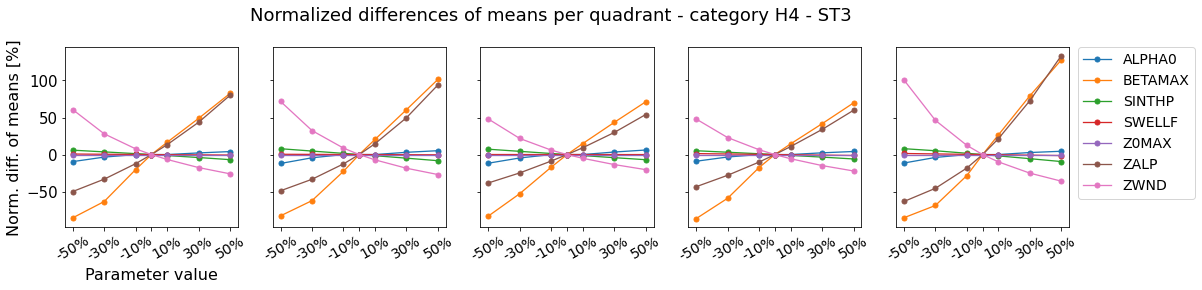

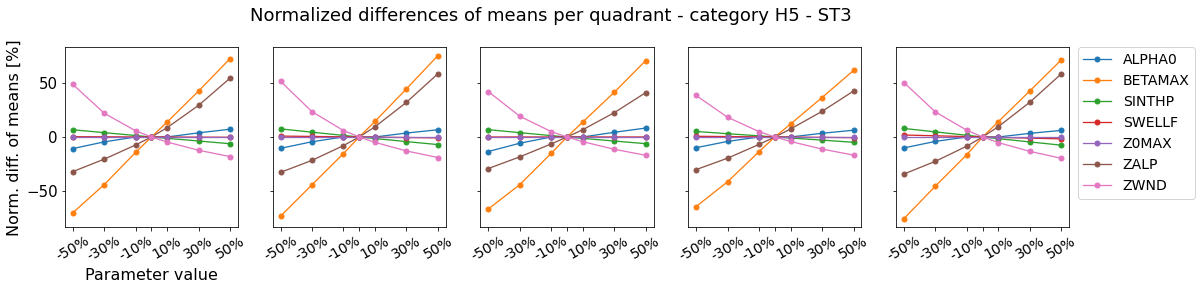

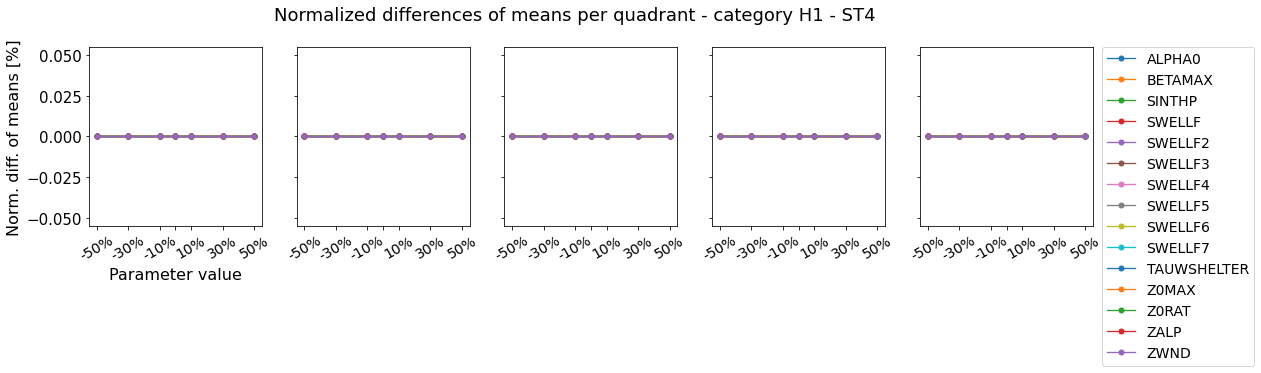

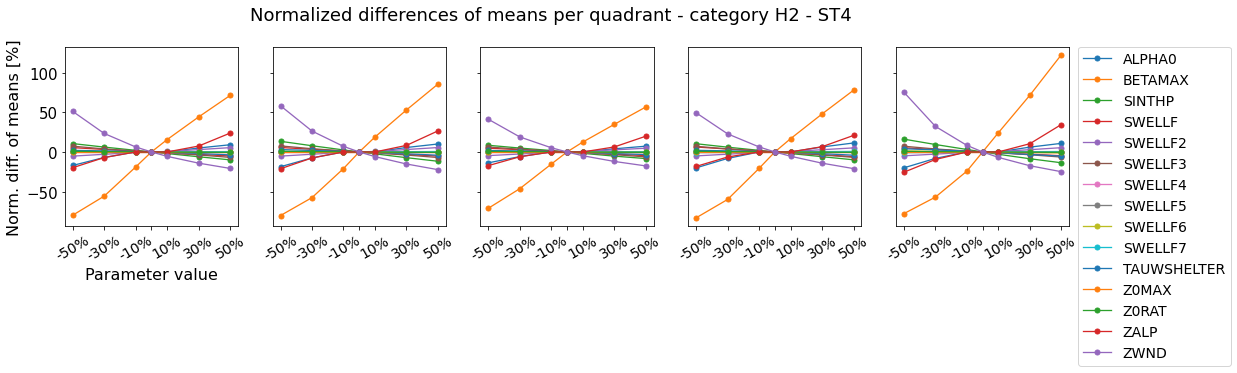

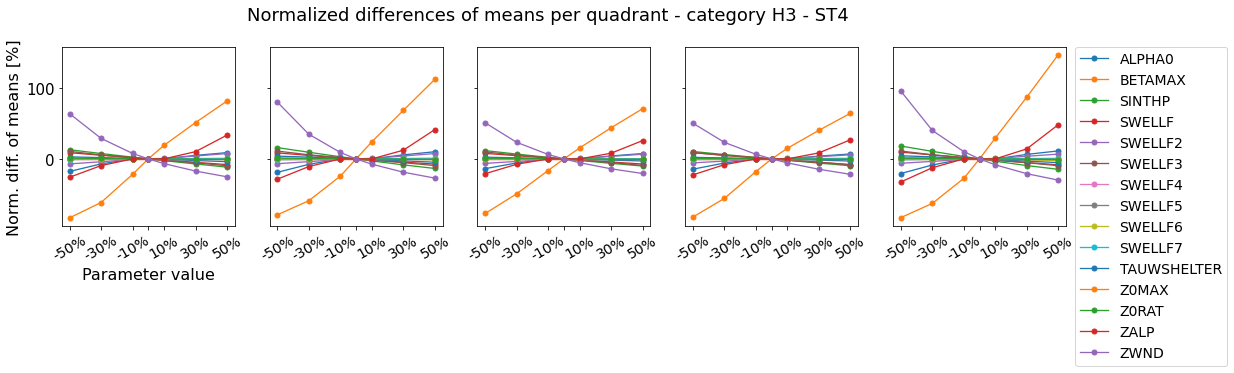

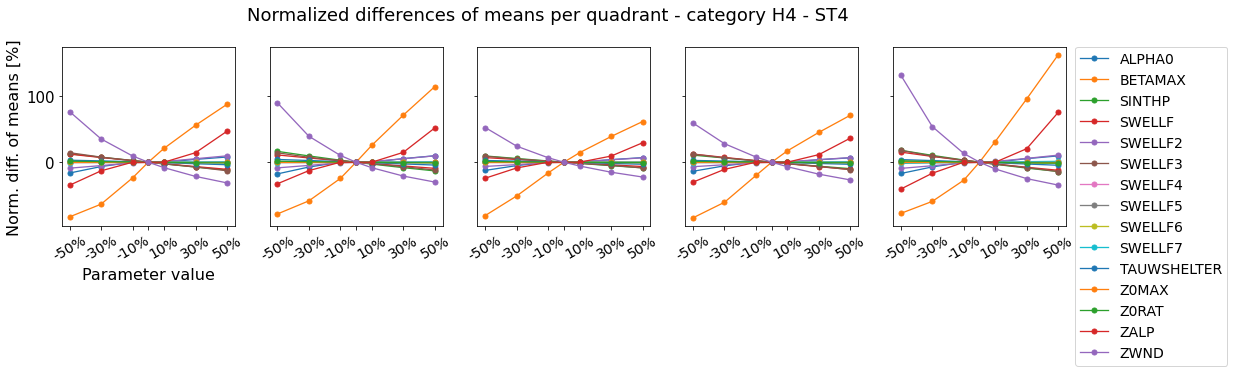

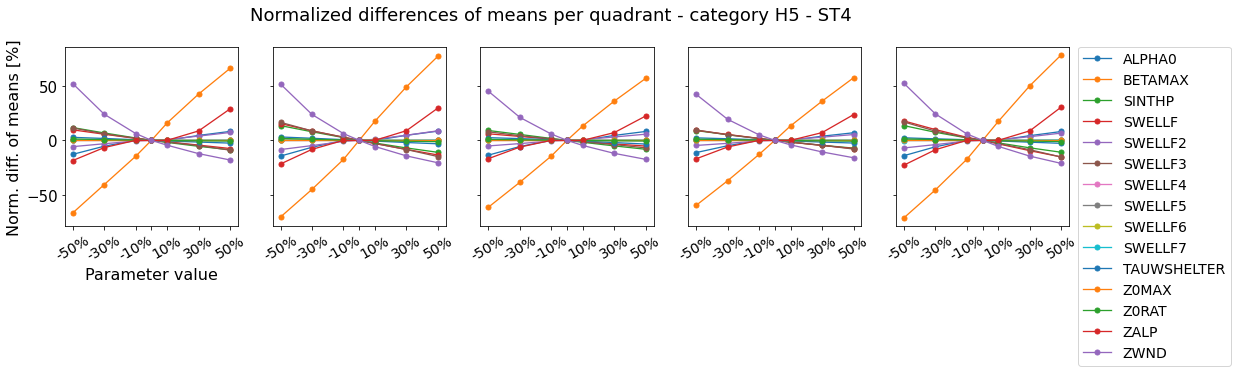

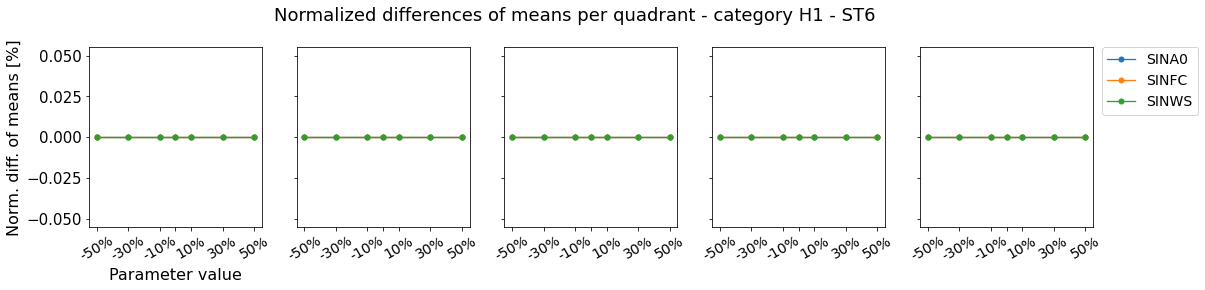

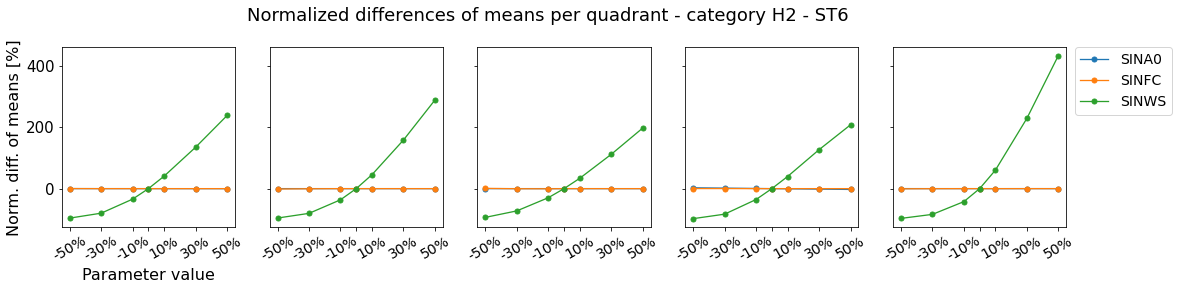

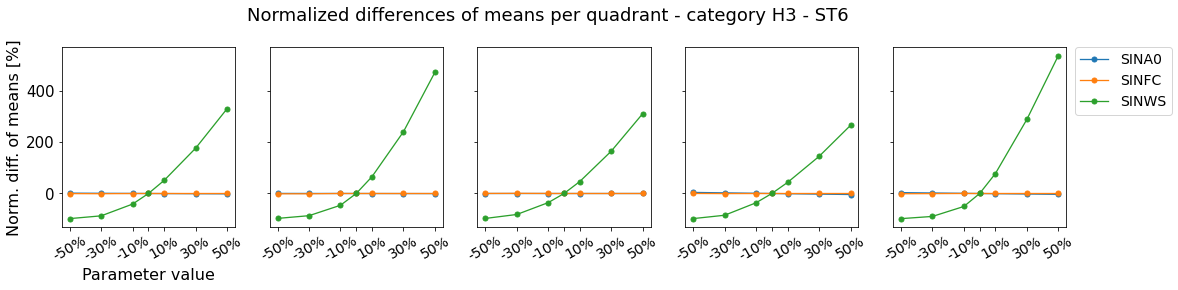

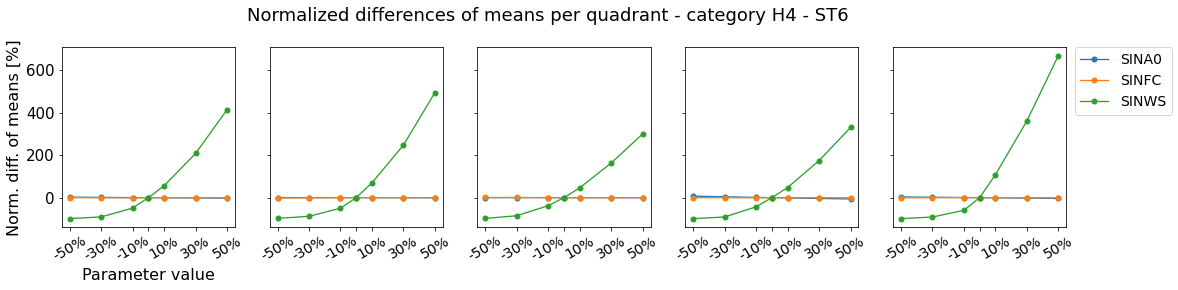

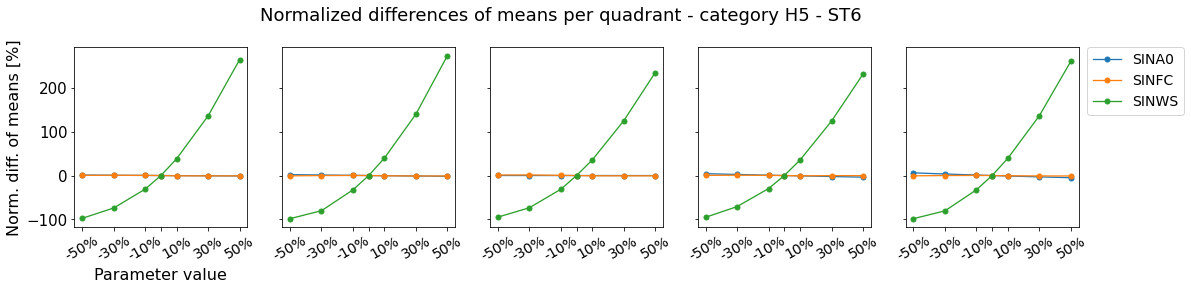

In [19]:
plotting_integral_plot_v2(parameter_list_st3,results_final_array_st3,'ST3')
plotting_integral_plot_v2(parameter_list_st4,results_final_array_st4,'ST4')
plotting_integral_plot_v2(parameter_list_st6,results_final_array_st6,'ST6')

# Plotting the integral parameters

In [ ]:
ds_parts=np.load('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/hs_part.npz',
                 allow_pickle=True)

In [ ]:
hs_parts_sw3=ds_parts['sw3'].flatten()[0]

In [ ]:
to_plot2=hs_parts_sw3['ALPHA0/-50']